In [1]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from utils.preprocessor import Stopwords_preprocessor
from utils.markdown import beir_metrics_to_markdown_table
from IPython.display import Markdown

# from rank_bm25 import BM25Okapi as BM25
from transformers import logging, AutoTokenizer
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval

In [3]:
import pathlib
import torch
from torch import nn

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# from beir import util
# dataset =  'trec-covid' # "nfcorpus" 
# url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
# data_path = util.download_and_unzip(url, 'data')

In [6]:
corpus_name = 'scifact'
# corpus_name = 'trec-covid'
# corpus_name = 'nfcorpus'

corpus, queries, qrels = GenericDataLoader(f'data/{corpus_name}').load(split="test")
corpus_text = [v['text'] for k,v in corpus.items()]

  0%|          | 0/5183 [00:00<?, ?it/s]

In [7]:
def tokenize(x):
    return tokenizer.convert_ids_to_tokens(tokenizer.encode(x, add_special_tokens=False))

vectorizer = TfidfVectorizer(tokenizer=tokenize, vocabulary=tokenizer.vocab)
%time vectorizer.fit(corpus_text)

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5.96 s, sys: 45 ms, total: 6 s
Wall time: 5.98 s


TfidfVectorizer(tokenizer=<function tokenize at 0x7f1d3d147c40>,
                vocabulary={'!': 999, '"': 1000, '#': 1001, '##!': 29612,
                            '##"': 29613, '###': 29614, '##$': 29615,
                            '##%': 29616, '##&': 29617, "##'": 29618,
                            '##(': 29619, '##)': 29620, '##*': 29621,
                            '##+': 29622, '##,': 29623, '##-': 29624,
                            '##.': 29625, '##/': 29626, '##0': 2692,
                            '##00': 8889, '##01': 24096, '##0s': 16223,
                            '##1': 2487, '##10': 10790, '##100': 18613,
                            '##11': 14526, '##12': 12521, '##13': 17134,
                            '##14': 16932, '##15': 16068, ...})

In [8]:
# # test
# text_sample = corpus[list(corpus.keys())[0]]['text']
# res = mean_rotary_discrepency(text_sample)
# res.shape

In [10]:
import numpy as np
import torch
import torch.nn as nn

class Absolute_attention(nn.Module):
  def __init__(self, dim=256, num_heads=16, hidden_dim=None, time_dim=64):
    super().__init__()

    self.dim = dim
    self.num_heads = num_heads
    self.time_dim = time_dim

    if isinstance(hidden_dim, int):
      self.hidden_dim = hidden_dim
    else:
      assert dim % num_heads == 0
      self.hidden_dim = dim // num_heads

    # assert self.hidden_dim % 2 == 0
    # self.time_embedding = time_embedding
    self.time_angle = nn.Parameter(torch.rand(self.num_heads, self.time_dim))
    self.head_time_delta = nn.Parameter(torch.rand(self.num_heads))

    self.Q = nn.Linear(dim, num_heads * (self.hidden_dim + 1), bias=False)
    self.K = nn.Linear(dim, num_heads * self.hidden_dim, bias=False)
    self.V = nn.Linear(dim, num_heads * self.hidden_dim, bias=False)
    self.O = nn.Linear(num_heads * self.hidden_dim, dim)

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, tensor, attention_mask):
    batch_length = tensor.shape[:2]
    # print(f'{tensor.shape=}')
    q = self.Q(tensor).view(*batch_length, self.num_heads, self.hidden_dim + 1)
    # q = (q + attention_mask[..., None, None])
    q = q.softmax(dim=-1)

    time_angles = (torch.arange(batch_length[1]).to(self.head_time_delta.device)[:, None, None]
                   + self.head_time_delta[None, :, None]) * self.time_angle  # shape: [length, num_heads, dim_time] ?
    cosines, sines = time_angles.cos(), time_angles.sin()
    time = torch.cat([cosines + sines, cosines - sines], dim=-1) / np.sqrt(self.hidden_dim)  # shape: [length, num_heads, 2*dim_time] ?
    q = (1 - q[..., -1, None]) * time
    # q shape: [batch_size, length, num_heads, 2*dim_time] = [batch_size, length, 1, 1] * [length, num_heads, 2*dim_time] ?

    k = self.K(tensor).view(*batch_length, self.num_heads, self.hidden_dim)  # bthd
    k = k.softmax(dim=-1) * attention_mask[..., None, None]

    k_time_angles = torch.arange(batch_length[1]).to(self.time_angle.device)[:, None, None] * self.time_angle
    k_cosines, k_sines = time_angles.cos(), time_angles.sin()
    k_time = torch.cat([k_cosines + k_sines, k_cosines - k_sines], dim=-1) / np.sqrt(self.hidden_dim)

    attention = torch.einsum('blhd,thd->blth', q, k_time)

    v = self.V(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    adding_comb = torch.einsum('blth,bthd->blhd', attention, v)

    output = self.O(adding_comb.reshape(*batch_length, self.dim))

    return self.dropout(output)

class Absolute_bert(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, attention_type=Absolute_attention, dtype=torch.float):
    super().__init__()
    self.vocab_size = vocab_size
    self.dim = dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.depth = depth

    self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.nn.init.xavier_normal_(torch.ones([vocab_size, self.dim])))
    # self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.rand(vocab_size, self.dim) / np.sqrt(self.dim))

    self.layers = nn.ModuleList([Absolute_attention(dim=dim,
      num_heads=num_heads,
      hidden_dim=hidden_dim
      ) for _ in range(depth)])
    self.dtype = dtype

  def forward(self, input_ids, attention_mask, **kwargs):
    # extended_attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
    # extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(self.dtype).min

    tensor = self.embedding(input_ids)

    for layer in self.layers:
      output = layer(tensor, attention_mask)
      tensor = tensor + output

    return tensor

class Absolute_bert_for_masked_LM(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, **kwargs):
    super().__init__()
    self.base_model = Absolute_bert(vocab_size, dim, num_heads, hidden_dim, depth, **kwargs)
    self.bias = nn.Parameter(torch.zeros(vocab_size))

  def forward(self, input_ids, attention_mask, labels, **kwargs):
    tensor = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    return tensor, labels

  def word_embeddings(self):
    return self.base_model.embedding.weight

weight norms, min: 0.1553989201784134, max: 0.35093221068382263
min norms: ['kitchen', '[MASK]', 'amelie', 'councillors', 'camden', '##dial', 'sees', 'spence', 'arenas', 'sourced']
max norms: ['for', ')', '(', 'a', 'of', 'in', 'and', ',', '.', 'the']
bias norms, min: -0.00400241743773222, max: 0.024706829339265823
min norms: ['[PAD]', '[unused736]', 'ಾ', 'gasps', '[unused988]', '[unused525]', 'ɒ', '##ை', '[unused126]', 'gasped']
max norms: ['november', '6', ',', '8', 'b', '1997', '18', 'japanese', 'book', 'often']


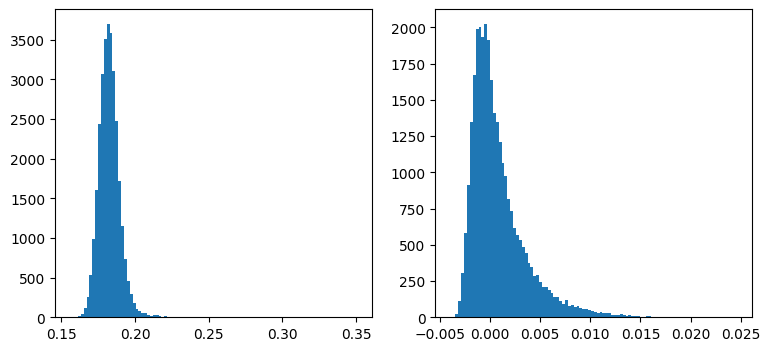

In [49]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
subpath = '20240709.11:13:35' # abs_architecture, original in 59, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000
subpath = '20240709.15:13:59' # add back all the biases
subpath = '20240709.16:56:30' 
subpath = '20240710.02:31:19' # sum_of_softmax
subpath = '20240710.03:33:50' # e1_as_pivot
subpath = '20240710.15:09:00' # e1_as_pivot
subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15

epoch_num = 0
batch_num = 5000

folder_path = pathlib.Path('data/limanet/')
# model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')

word_reprs = model.word_embeddings().detach()

vectors = word_reprs

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(vectors, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [50]:
def mean_vector(text, word_reprs=word_reprs):
  ids = tokenizer.encode(text, add_special_tokens=False)
  if len(ids) == 0:
      return np.zeros(word_reprs.shape[1])
  return word_reprs[ids].mean(axis=0)

def sum_vector(text):
  ids = tokenizer.encode(text, add_special_tokens=False)
  return word_reprs[ids].sum(axis=0)


def idf_mean_vector(text, word_reprs=word_reprs):
  ids = tokenizer.encode(text, add_special_tokens=False)
  # return (vectorizer.idf_[ids] @ word_reprs[ids]) / (len(ids) + 1e-8) # 這個比較慢，可能跟 contiguous 有關
  return np.einsum('ld,l', word_reprs[ids], vectorizer.idf_[ids]) / (len(ids) + 1e-8)

from sklearn.metrics.pairwise import cosine_similarity
mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
score = cosine_similarity(word_reprs, word_reprs[[mask_id]])
score = 1 - np.maximum(score, 0)
scored_word_reprs = torch.from_numpy(score) * word_reprs

# def cos_scored_mean_vector(text):
#   ids = tokenizer.encode(text, add_special_tokens=False)
  # return scored_word_reprs[ids].sum(axis=0)

cos_weighted_mean_vector = lambda text: mean_vector(text, scored_word_reprs)
cos_weighted_idf_mean_vector = lambda text: idf_mean_vector(text, scored_word_reprs)

max_norm = word_reprs[norms.argmax()]
score = cosine_similarity(word_reprs, [max_norm])
bipolar_reprs = torch.from_numpy(1 - np.abs(score)) * word_reprs

bipolar_weighted_mean_vector = lambda text: mean_vector(text, bipolar_reprs)
bipolar_weighted_if_mean_vector = lambda text: idf_mean_vector(text, bipolar_reprs)

In [51]:
# inputs = tokenizer('I love you.', return_tensors='pt', add_special_tokens=False)
# histories = [his.expand(4, *[-1]*(len(his.shape)-1)) for his in model.initial_states()['histories']]
# output, next_histories = model.forward(inputs['input_ids'][0], 1, histories)

In [52]:
method = idf_mean_vector
method = mean_vector
# method = sum_vector
# method = cos_weighted_mean_vector
# method = cos_weighted_idf_mean_vector
# method = bipolar_weighted_mean_vector
# method = bipolar_weighted_if_mean_vector

part = 'text'
# part = 'title'

%time text_vec_dict = OrderedDict({k: method(v[part]) for k, v in corpus.items()})
%time query_vec_dict = OrderedDict({k: method(v) for k, v in queries.items()})
text_vecs = np.stack(list(text_vec_dict.values()))

CPU times: user 3min 41s, sys: 90.4 ms, total: 3min 41s
Wall time: 6.16 s
CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 66 ms


In [53]:
metric = 'euclidean'
metric = 'cosine'

def score(query_vector, metric=metric):
    return (1/pairwise_distances(query_vector[None, :], text_vecs, metric=metric))[0]

%time results = {qid: dict(zip(text_vec_dict.keys(), score(query_vector).tolist())) \
            for qid, query_vector in query_vec_dict.items()}

metrics = EvaluateRetrieval.evaluate(qrels, results, [1, 3, 5, 10, 100, 1000])

flatten_metrics = {k: v for metric_type in metrics for k, v in metric_type.items()}
metric_names, metric_values = zip(*flatten_metrics.items())
print(*metric_names, sep='\t')
print(*metric_values, sep='\t')
print()

md = beir_metrics_to_markdown_table(*metrics)
Markdown(md)

CPU times: user 53 s, sys: 2min 54s, total: 3min 47s
Wall time: 3.75 s
NDCG@1	NDCG@3	NDCG@5	NDCG@10	NDCG@100	NDCG@1000	MAP@1	MAP@3	MAP@5	MAP@10	MAP@100	MAP@1000	Recall@1	Recall@3	Recall@5	Recall@10	Recall@100	Recall@1000	P@1	P@3	P@5	P@10	P@100	P@1000
0.28	0.34541	0.36051	0.38101	0.41828	0.44559	0.26556	0.32495	0.33333	0.34255	0.35022	0.35116	0.26556	0.39194	0.42778	0.48722	0.66217	0.87833	0.28	0.14	0.092	0.05267	0.0074	0.00099



||NDCG|MAP|Recall|P|
|-|-|-|-|-|
|@1|0.2800|0.2656|0.2656|0.2800|
|@3|0.3454|0.3250|0.3919|0.1400|
|@5|0.3605|0.3333|0.4278|0.0920|
|@10|0.3810|0.3426|0.4872|0.0527|
|@100|0.4183|0.3502|0.6622|0.0074|
|@1000|0.4456|0.3512|0.8783|0.0010|

In [ ]:
20240710.23:13:03 all1_as_pivot
0.28333	0.35116	0.37325	0.3929	0.42589	0.45214	0.26722	0.32875	0.34142	0.3503	0.35664	0.35756	0.26722	0.4	0.45333	0.51056	0.66661	0.875	0.28333	0.14333	0.09667	0.055	0.00747	0.00098

2000
0.29667	0.36094	0.38013	0.3938	0.42943	0.45456	0.28222	0.33949	0.35046	0.35662	0.36379	0.36467	0.28222	0.40833	0.45444	0.49472	0.66189	0.861	0.29667	0.14556	0.09733	0.05367	0.00747	0.00097

5000
0.28	0.34541	0.36051	0.38101	0.41828	0.44559	0.26556	0.32495	0.33333	0.34255	0.35022	0.35116	0.26556	0.39194	0.42778	0.48722	0.66217	0.87833	0.28	0.14	0.092	0.05267	0.0074	0.00099


20240710.15:09:00 e1_as_pivot
0.29667	0.34786	0.36542	0.38364	0.42196	0.44796	0.28444	0.3313	0.34157	0.34925	0.35645	0.35732	0.28444	0.38167	0.42444	0.47833	0.66167	0.86856	0.29667	0.13667	0.09133	0.05233	0.00737	0.00098

2000
0.29667	0.34141	0.35487	0.37834	0.41378	0.43959	0.27806	0.32333	0.33061	0.34079	0.34793	0.34881	0.27806	0.37722	0.41167	0.48083	0.64667	0.85039	0.29667	0.13444	0.088	0.053	0.0072	0.00096



In [21]:
inputs = tokenizer('I love you.', return_tensors='pt', add_special_tokens=False)
histories = [his.expand(4, *[-1]*(len(his.shape)-1)) for his in model.initial_states()['histories']]
output, next_histories = model.forward(inputs['input_ids'][0], 1, histories)

AttributeError: 'Absolute_bert_for_masked_LM' object has no attribute 'initial_states'

In [ ]:
# for i in range(len(model.limas)):
#     lima_shape = model.limas[i].lima_shape
#     print(lima_shape)
#     print(f'{i}: {lima_shape.min()}, {lima_shape.max()}')

In [22]:
model.predictor.rotary_denom

AttributeError: 'Absolute_bert_for_masked_LM' object has no attribute 'predictor'

In [23]:
# # write first 10 questions and top 10 answer to file

# samples = list(results.items())[:10]
# for q_num, score_dict in samples:
#     with open(f'question_{q_num}.txt', 'w') as f:
#         f.write(f'{queries[q_num]}\n\n')
#         tokens = tokenizer.convert_ids_to_tokens(tokenizer(queries[q_num], add_special_tokens=False)['input_ids'])
#         f.write(f'{tokens}\n\n')
        
#         text_ids, text_scores = zip(*score_dict.items())
#         text_scores = np.array(text_scores)
#         top_10_idx = np.argsort(text_scores)[:-10:-1]

#         for idx in top_10_idx:
#             f.write(f'{corpus[text_ids[idx]]}\n\n')

In [18]:
# #test: 看每個字往時間方向逆向轉一個 t 後，附近的字為何。理論來說會是跟這個字無關的字 (text independent)，因為這個旋轉抵銷了時間旋轉

# inverse_metric_theta = - 1/model.predictor.rotary_denom**(model.predictor.dimension_nums/model.predictor.dim)
# inverse_pos_rotation = torch.complex(inverse_metric_theta.cos(), inverse_metric_theta.sin())
# least_effective_position_of_the_word = model.predictor.all_word_embeddings() * inverse_pos_rotation
# least_effective_position_of_the_word = torch.concat([least_effective_position_of_the_word.real, least_effective_position_of_the_word.imag], dim=-1).detach().numpy()

# least_effective_position_of_the_word.shape

# %time d = pairwise_distances(word_reprs, least_effective_position_of_the_word, metric='euclidean') # metric='cosine'

# %time pair = d.argsort(axis=1)[:, :10]

# for input_id in tokenizer.encode(text_sample):
#     print(f'{tokenizer.convert_ids_to_tokens(input_id)}: {tokenizer.convert_ids_to_tokens(pair[input_id])}')